<p><a name="title"></a></p>
## How much is your house worth?
<br>
<p><a name="intro"></a></p>
### Introduction
<br>
<br>
Deep learning and Machine learning are becoming more and more important for enterprises. 

For this project, I have developped algorithms which use a broad spectrum of features to predict realty prices. The analysis relies on a rich dataset that includes housing data and macroeconomic patterns.

Being a data scientist is like being a detective without being one. “There's the joke that 80 percent of data science is cleaning the data and 20 percent is complaining about cleaning the data,” Kaggle founder and CEO Anthony Goldbloom told The Verge over email. “In reality, it really varies. But data cleaning is a much higher proportion of data science than an outsider would expect. Actually training models is typically a relatively small proportion (less than 10 percent) of what a machine learner or data scientist does.”

I've used data from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), who compiled a detailed dataset of residential property sales in a North American city. It is used in one of the most popular practice [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competitions. This dataset is characterised by a large number of predictor variables (including categorical, ordinal, discrete, and continuous variables). See the [documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) for a description of the original variables.

The business objective is to predict the final price of each home based on explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. There are many models available for forecasting. In general, more advanced techniques such as stacking produces small gains with a lot of added complexity – not worth it for most businesses. But Stacking is almost always fruitful so it’s almost always used in top Kaggle solutions.
<br>
<br>


**Future Direction**
<br>
<br>
Given all the hype on stacking and XGBoost, it'll be interesting to spend more time hypertuning models and see if that will give better test results. We can also try different combinations of models when using the stacking/ensembling techniques. What I have learning over the course of this project is that machine learning is an art that can be perfected over time!

<p><a name="table_content"></a></p>
## Project Workflow
- <a href="#HousepricesData">1. House prices Data</a><br>
- <a href="#Addingnewfeatures">2. Adding new features</a><br>
- <a href="#MissingnessImputation">3. Missingness and Imputation</a><br>
- <a href="#ExploratoryDataAnalysisDataTransformation">4. Exploratory Data Analysis and Data Transformation</a><br>
- <a href="#ModelingandHyperparameterTuning">5. Modeling and Hyperparameter Tuning</a><br>
- <a href="#Prediction">6. Prediction</a><br>

This notebook relies on the following libraries and settings.

In [1]:
##--Packages
import numpy as np
from numpy import NaN
from scipy import stats
from scipy.stats import norm, skew
import pandas as pd
import matplotlib.pyplot as plt
import pylab as P
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
##--Plot settings
%matplotlib inline

In [3]:
##--Model selection and evaluation tools
import sklearn.model_selection as ms
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import lightgbm as lgb

<p><a name="HousepricesData"></a></p>
### 1. House prices Data
Let's start by loading the data.

In [5]:
##--Load training data
train = pd.read_csv("data/train.csv", header = 0, index_col=None).drop("Id",axis=1)
##--Load test data
test = pd.read_csv("data/test.csv", header = 0, index_col=None).drop("Id",axis=1)

print('The shape of the original train data set is %s' %str(train.shape))
print('The shape of the original test data set used for model evaluation is %s' %str(test.shape))
train.head()

The shape of the original train data set is (1460, 80)
The shape of the original test data set used for model evaluation is (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<p><a name="Addingnewfeatures"></a></p>
### 2. Adding new features
We now create new feature *YearMonth* to then be able to merge the 5-Years and 10-Years interest rates, as well as convert the new feature as datetime values.

In [7]:
##--Convert YearMonth as datetime values
train['YearMonth']=(train['YrSold']).apply(str) + str("-") + (train['MoSold']).apply(str) + str("-01")
test['YearMonth']=(train['YrSold']).apply(str) + str("-") + (test['MoSold']).apply(str) + str("-01")
train['YearMonth'] =  pd.to_datetime(train['YearMonth'], format='%Y-%m-%d').dt.date
test['YearMonth'] =  pd.to_datetime(test['YearMonth'], format='%Y-%m-%d').dt.date

In [8]:
##--Load new feature 5-Years interest rate
FVX = pd.read_csv("data/FVX.csv", header = 0, index_col=None)
FVX['YearMonth'] =  pd.to_datetime(FVX['YearMonth'], format='%Y-%m-%d').dt.date

##--Load new feature 10-Years interest rate
TNX = pd.read_csv("data/TNX.csv", header = 0, index_col=None)
TNX['YearMonth'] =  pd.to_datetime(TNX['YearMonth'], format='%Y-%m-%d').dt.date

##--Merge the 5-Years and 10-Years interest rates
def merge_dfs(df):
    df = pd.merge(df,FVX[['YearMonth','Close']],on='YearMonth', how='left')
    df = df.rename(columns={'Close': '5-Years interest rate'})

    df = pd.merge(df,TNX[['YearMonth','Close']],on='YearMonth', how='left')
    df = df.rename(columns={'Close': '10-Years interest rate'})

    return df

In [9]:
train = merge_dfs(train)
test = merge_dfs(test)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearMonth,5-Years interest rate,10-Years interest rate
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,2,2008,WD,Normal,208500,2008-02-01,2.509,3.534
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,0,5,2007,WD,Normal,181500,2007-05-01,4.853,4.890
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,9,2008,WD,Normal,223500,2008-09-01,2.986,3.827
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,0,2,2006,WD,Abnorml,140000,2006-02-01,4.601,4.547
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,0,12,2008,WD,Normal,250000,2008-12-01,1.551,2.244


In [10]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearMonth,5-Years interest rate,10-Years interest rate
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,MnPrv,NaN,0,6,2010,WD,Normal,2008-06-01,3.341,3.979
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,Gar2,12500,6,2010,WD,Normal,2007-06-01,4.936,5.033
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,MnPrv,NaN,0,3,2010,WD,Normal,2008-03-01,2.467,3.432
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,6,2010,WD,Normal,2006-06-01,5.098,5.138
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,NaN,NaN,0,1,2010,WD,Normal,2008-01-01,2.826,3.639


#### <p><a name="MissingnessImputation"></a></p>
### 3. Missingness and Imputation
Many statistical methods and machine learning techniques have difficulty incorporating incomplete observations in their algorithms. The process of “filling in” missing values is called imputation. Starting with the numerical values, we see that the features *LotFrontage*, *MasVnrArea*, and *GarageYrBlt* have missing values. Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the mean *LotFrontage* of the neighborhood. For the feature *MasVnrArea* and most of other features in the list, NA most likely means no masonry veneer for these houses. We can fill 0 for the area. Finally, we'll replace the *GarageYrBlt* value missing with the year the house was built. Most garages are built at the same time as the house, and houses without garages get no penalty or benefit by having the Garage Year Built equal to the Year Built for the house.

In [11]:
train_num = train._get_numeric_data()
train_num = pd.DataFrame(np.sum(train_num.isnull())).rename(columns={0: 'Number of missing values for numerical data'})
train_num = train_num[(train_num>0).any(axis=1)]
train_num

,Number of missing values for numerical data
LotFrontage,259
MasVnrArea,8
GarageYrBlt,81


In [12]:
test_num = test._get_numeric_data()
test_num = pd.DataFrame(np.sum(test_num.isnull())).rename(columns={0: 'Number of missing values for numerical data'})
test_num = test_num[(test_num>0).any(axis=1)]
test_num

,Number of missing values for numerical data
LotFrontage,227
MasVnrArea,15
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
TotalBsmtSF,1
BsmtFullBath,2
BsmtHalfBath,2
GarageYrBlt,78
GarageCars,1


In [13]:
##--Impute values to missing numerical data

train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
for column in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea'):
    test[column] = test[column].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['YearBuilt'])

We now transform variables that are really categorical. We will see later that with the concept of seasonality, the feature MoSold should be treated as a categorical feature.

In [14]:
pd.set_option('display.max_rows', 400)
pd.DataFrame(train.dtypes)

,0
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
Street,object
Alley,object
LotShape,object
LandContour,object
Utilities,object
LotConfig,object


In [15]:
pd.DataFrame(test.dtypes)

,0
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
Street,object
Alley,object
LotShape,object
LandContour,object
Utilities,object
LotConfig,object


In [16]:
for column in ('MSSubClass','OverallQual','OverallCond'):
    train[column] = train[column].apply(str)
    test[column] = test[column].apply(str)

Let's now see how many missing values there are for the categorical data.

In [17]:
train_cat = pd.DataFrame(np.sum(train.isnull())).rename(columns={0: 'Number of missing values for categorical data'})
train_cat = train_cat[(train_cat>0).any(axis=1)]
train_cat

,Number of missing values for categorical data
Alley,1369
MasVnrType,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1
FireplaceQu,690
GarageType,81


In [18]:
test_cat = pd.DataFrame(np.sum(test.isnull())).rename(columns={0: 'Number of missing values for categorical data'})
test_cat = test_cat[(test_cat>0).any(axis=1)]
test_cat

,Number of missing values for categorical data
MSZoning,4
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,16
BsmtQual,44
BsmtCond,45
BsmtExposure,44
BsmtFinType1,42


For most of the features in this situation with less than 5 missing values, we will impute the mode. For *MasVnrType*, we'll assume that the missing values correspond to "None" and therefore impute that value. As for the rest of the features with missing values, we can associate them to "None" per the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt). There is an exception (Id 333) that will be treated manually as there is information on Type 2 finished square feet (*BsmtFinSF2*), and therefore there should be a Rating of basement finished area for this observation with multiple types (*BsmtFinType2*). We will use the same quality as *BsmtFinType1*.

In [19]:
##--Impute mode to missing categorical data

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
for column in ('MSZoning','Utilities','Functional','SaleType'):
    test[column] = test[column].fillna(test[column].mode()[0])

##--Impute "None" to missing categorical data

for column in ('Alley','MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','Fence','MiscFeature'):
    train[column] = train[column].fillna('None')
    test[column] = test[column].fillna('None')
    
##--Impute value to exception Id 333
train.loc[332, 'BsmtFinType2']=train.loc[332, 'BsmtFinType1']

##--Exceptions : mode grouped by Neighborhood
test.loc[691,'Exterior1st']='Wd Sdng'
test.loc[691,'Exterior2nd']='Wd Sdng'
test.loc[95,'KitchenQual']='TA'

<p><a name="ExploratoryDataAnalysisDataTransformation"></a></p>
### 4. Exploratory Data Analysis and Data Transformation
Exploratory data analysis (EDA) is the process of discovering features and patterns in the data that should inform the modelling process and in some cases prevent errors.

**How Seasonality Works for Home Buyers**
<br>
<br>
Due to the fluctuations in supply and demand, it’s during "seasonal pattern" that we find there isn't as much competition from the average homebuyer. With summer being the busiest moving time of year, people buy more aggressively than in the winter, limiting the number of available houses and raising market prices. In the winter, though, since nobody wants to deal with the inconvenience of moving during this time, these low-demand periods are perfect for those who are looking for a good deal. Because sellers aren’t necessarily getting a lot of interest or offers from others, they’re more willing to negotiate and therefore results with a substantial discount on pricing. We can visualize this with our train data and see that the SalePrice totals are highest in June and July. Because of seasonality, we can convert the MoSold feature as a categorical feature.

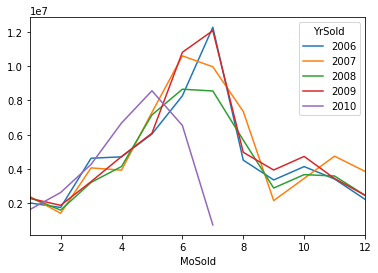

In [20]:
pv = pd.pivot_table(train, index=train.MoSold, columns=train.YrSold, values='SalePrice', aggfunc='sum')
pv.plot()

In [21]:
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)

Let's look at the responsiveness of house prices to US 5 and 10 Years interest rates as it'll be interesting to see the macroeconomics patterns.

In [22]:
#Group per YearMonth to see the evolution over time
monthly = train.groupby(['YearMonth']).mean()
monthly = pd.DataFrame(monthly)
monthly.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,5-Years interest rate,10-Years interest rate
YearMonth,,,,,,,,,,,,,,,,,,,,,
2006-01-01,80.747325,15001.900000,1975.400000,1985.900000,96.900000,582.300000,105.900000,606.100000,1294.300000,1394.400000,...,79.500000,16.000000,0.00,0.000000,64.80,0.000000,2006.0,201090.000000,4.463,4.527
2006-02-01,70.774603,10559.777778,1981.777778,1992.333333,102.111111,554.666667,22.444444,441.111111,1018.222222,1077.555556,...,73.666667,30.222222,0.00,0.000000,0.00,0.000000,2006.0,194322.222222,4.601,4.547
2006-03-01,77.705313,10202.480000,1975.960000,1983.760000,140.320000,442.480000,56.640000,605.360000,1104.480000,1185.600000,...,54.440000,40.640000,6.72,10.360000,20.48,28.000000,2006.0,184982.200000,4.814,4.853
2006-04-01,56.697023,8340.703704,1975.444444,1983.703704,90.666667,353.333333,43.703704,653.333333,1050.370370,1133.370370,...,42.851852,14.037037,0.00,8.000000,0.00,18.518519,2006.0,174312.814815,4.920,5.069
2006-05-01,66.511597,9445.657895,1971.210526,1980.789474,103.842105,515.105263,55.736842,429.763158,1000.605263,1158.710526,...,51.684211,13.263158,0.00,13.473684,0.00,10.526316,2006.0,158928.289474,5.030,5.113


Text(0,0.5,'AverageSalePrice')

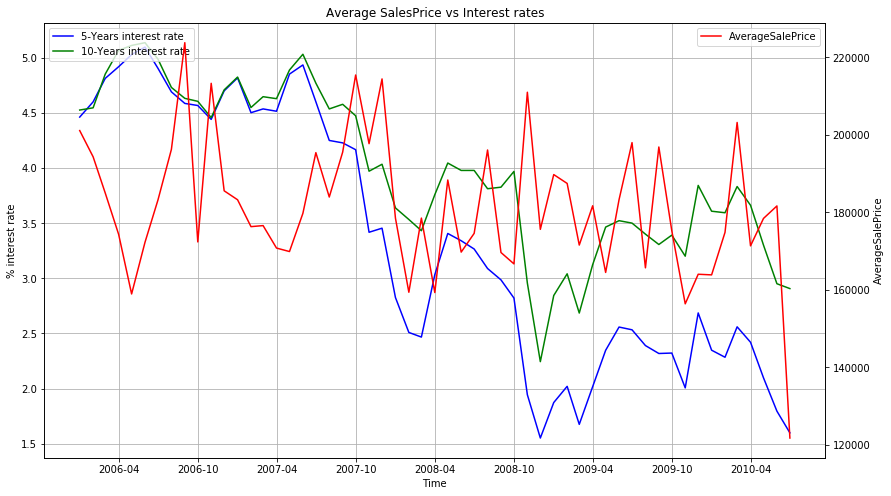

In [23]:
fig, ax1 = plt.subplots(figsize=(14, 8)) # allows to chart two series with different scales

plt.plot(monthly.iloc[:, -2], 'b', lw=1.5, label='5-Years interest rate')
plt.plot(monthly.iloc[:, -1], 'g', lw=1.5, label='10-Years interest rate')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
plt.xlabel('Time')
plt.ylabel('% interest rate')
plt.title('Average SalesPrice vs Interest rates')

ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for AverageSalePrice and it creates a mess

plt.plot(monthly.iloc[:,-3], 'r', lw=1.5, label='AverageSalePrice')
plt.legend(loc=0) #enter the legend 
plt.ylabel('AverageSalePrice')

This graph suggests that lags of interest rate changes would have to be included in an empirical model of house price determination. Using the correlation matrix, we can determine the lagging period by shifting the interest rates as well as the best interest rate to use. We'll select the interest rate with the highest correlation to the SalePrice by testing over a 12 periods.

In [24]:
FVX_corr = []
TNX_corr = []

for i in range(0,13):
    FVX_shifted = FVX.copy()
    FVX_shifted['Close']=FVX_shifted['Close'].shift(i)
    TNX_shifted = TNX.copy()
    TNX_shifted['Close']=TNX_shifted['Close'].shift(i)

    def merge_dfs_shifted(df):
        df = pd.merge(df,FVX_shifted[['YearMonth','Close']],on='YearMonth', how='left')
        df = df.rename(columns={'Close': 'Shifted 5-Years interest rate'})

        df = pd.merge(df,TNX_shifted[['YearMonth','Close']],on='YearMonth', how='left')
        df = df.rename(columns={'Close': 'Shifted 10-Years interest rate'})

        return df

    train_shifted = merge_dfs_shifted(train)

    #Group per YearMonth to see the evolution over time for the shifted interest rates of i periods.
    monthly_shifted = train_shifted.groupby(['YearMonth']).mean()
    monthly_shifted = pd.DataFrame(monthly_shifted)
    monthly_shifted_sub = monthly_shifted[['Shifted 5-Years interest rate','Shifted 10-Years interest rate','SalePrice']]
    corr_table = monthly_shifted_sub.corr(method='pearson')
    FVX_corr.append(corr_table.iloc[0,2])
    TNX_corr.append(corr_table.iloc[1,2])

In [25]:
max(FVX_corr)

0.33275093667661165

In [26]:
pd.DataFrame(FVX_corr)

,0
0,0.258357
1,0.288230
2,0.314335
3,0.332751
4,0.294497
5,0.325825
6,0.291964
7,0.241275
8,0.261861
9,0.238227


In [27]:
max(TNX_corr)

0.33607019014246736

In [28]:
pd.DataFrame(TNX_corr)

,0
0,0.200583
1,0.270300
2,0.302543
3,0.336070
4,0.282293
5,0.315367
6,0.248916
7,0.161352
8,0.228766
9,0.200207


Given the results above, a 3 periods Shifted 10-Years interest rate gives the best correlation. Therefore, we will shift the interest rates in both our train and test datasets.

In [29]:
#3 periods shift
FVX_shifted = FVX.copy()
FVX_shifted['Close']=FVX_shifted['Close'].shift(3)
TNX_shifted = TNX.copy()
TNX_shifted['Close']=TNX_shifted['Close'].shift(3)

def merge_dfs_shifted(df):
    df = pd.merge(df,FVX_shifted[['YearMonth','Close']],on='YearMonth', how='left')
    df = df.rename(columns={'Close': 'Shifted 5-Years interest rate'})

    df = pd.merge(df,TNX_shifted[['YearMonth','Close']],on='YearMonth', how='left')
    df = df.rename(columns={'Close': 'Shifted 10-Years interest rate'})

    return df

train_shifted = merge_dfs_shifted(train)
test_shifted = merge_dfs_shifted(test)

#Group per YearMonth to see the evolution over time for the shifted interest rates of 3 periods.
monthly_shifted = train_shifted.groupby(['YearMonth']).mean()
monthly_shifted = pd.DataFrame(monthly_shifted)
monthly_shifted_sub = monthly_shifted[['Shifted 5-Years interest rate','Shifted 10-Years interest rate','SalePrice']]
monthly_shifted_sub.corr(method='pearson')

,Shifted 5-Years interest rate,Shifted 10-Years interest rate,SalePrice
Shifted 5-Years interest rate,1.000000,0.974037,0.332751
Shifted 10-Years interest rate,0.974037,1.000000,0.336070
SalePrice,0.332751,0.336070,1.000000


In [30]:
train_shifted

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearMonth,5-Years interest rate,10-Years interest rate,Shifted 5-Years interest rate,Shifted 10-Years interest rate
0,60,RL,65.000000,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,208500,2008-02-01,2.509,3.534,3.418,3.972
1,20,RL,80.000000,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,5,2007,WD,Normal,181500,2007-05-01,4.853,4.890,4.503,4.550
2,60,RL,68.000000,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,9,2008,WD,Normal,223500,2008-09-01,2.986,3.827,3.341,3.979
3,70,RL,60.000000,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,2,2006,WD,Abnorml,140000,2006-02-01,4.601,4.547,4.425,4.500
4,60,RL,84.000000,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,12,2008,WD,Normal,250000,2008-12-01,1.551,2.244,2.986,3.827
5,50,RL,85.000000,14115,Pave,None,IR1,Lvl,AllPub,Inside,...,10,2009,WD,Normal,143000,2009-10-01,2.322,3.392,2.533,3.501
6,20,RL,75.000000,10084,Pave,None,Reg,Lvl,AllPub,Inside,...,8,2007,WD,Normal,307000,2007-08-01,4.251,4.537,4.853,4.890
7,60,RL,81.288889,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,11,2009,WD,Normal,200000,2009-11-01,2.006,3.201,2.390,3.401
8,50,RM,51.000000,6120,Pave,None,Reg,Lvl,AllPub,Inside,...,4,2008,WD,Abnorml,129900,2008-04-01,3.033,3.759,2.826,3.639
9,190,RL,50.000000,7420,Pave,None,Reg,Lvl,AllPub,Corner,...,1,2008,WD,Normal,118000,2008-01-01,2.826,3.639,4.167,4.475


Text(0,0.5,'AverageSalePrice')

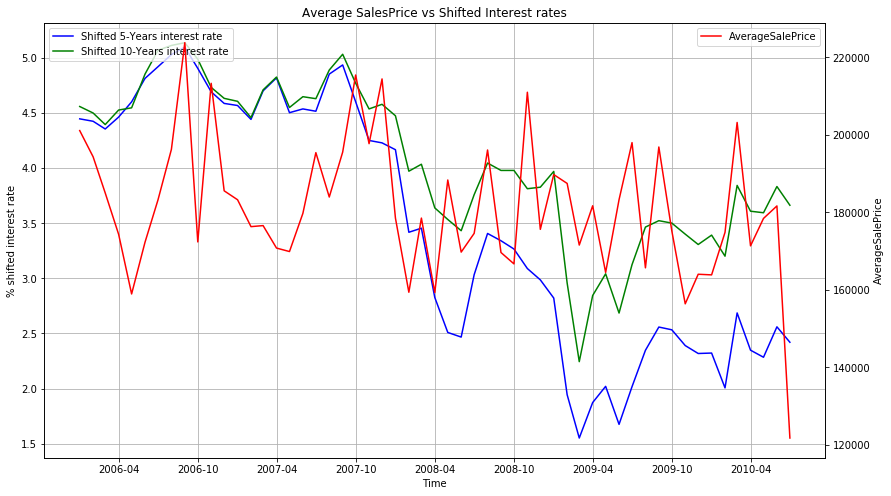

In [31]:
fig, ax1 = plt.subplots(figsize=(14, 8)) # allows to chart two series with different scales

plt.plot(monthly_shifted.iloc[:, -2], 'b', lw=1.5, label='Shifted 5-Years interest rate')
plt.plot(monthly_shifted.iloc[:, -1], 'g', lw=1.5, label='Shifted 10-Years interest rate')
plt.grid(True)
plt.legend(loc=2) #enter the legend 
plt.axis('tight')
plt.xlabel('Time')
plt.ylabel('% shifted interest rate')
plt.title('Average SalesPrice vs Shifted Interest rates')

ax2 = ax1.twinx() #generates a second axis object
plt.grid(False) # False; otherwise it plots also grids for AverageSalePrice and it creates a mess

plt.plot(monthly_shifted.iloc[:,-5], 'r', lw=1.5, label='AverageSalePrice')
plt.legend(loc=0) #enter the legend 
plt.ylabel('AverageSalePrice')

We can now remove unused features for the modeling.

In [32]:
#--Dropping unused columns
train_shifted.drop(['YrSold','YearMonth','5-Years interest rate','10-Years interest rate','Shifted 5-Years interest rate'], axis=1, inplace=True)
test_shifted.drop(['YrSold','YearMonth','5-Years interest rate','10-Years interest rate','Shifted 5-Years interest rate'], axis=1, inplace=True)

Merge similar levels for categorical data. Let's generate the list of categorical data again.

In [33]:
#--Finding list of categorical data
cat_list = train_shifted.loc[:, train_shifted.dtypes == object].columns

X_train = train_shifted.drop('SalePrice', 1)
Y_train = pd.Series(train_shifted['SalePrice'])
cat_list

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [158]:
#--Plot MSSubClass to relevel
order_index = pd.DataFrame(train_shifted.groupby(['MSSubClass']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.MSSubClass, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

KeyError: 'MSSubClass'

From the graph above, for the train and test datasets, we can group (40-160), (90-190). We'll change to the mode between the two groups.

In [36]:
train_shifted['MSSubClass'] = train_shifted.MSSubClass.replace({'40' : '160','190' : '90'})
test_shifted['MSSubClass'] = test_shifted.MSSubClass.replace({'40' : '160','190' : '90'})

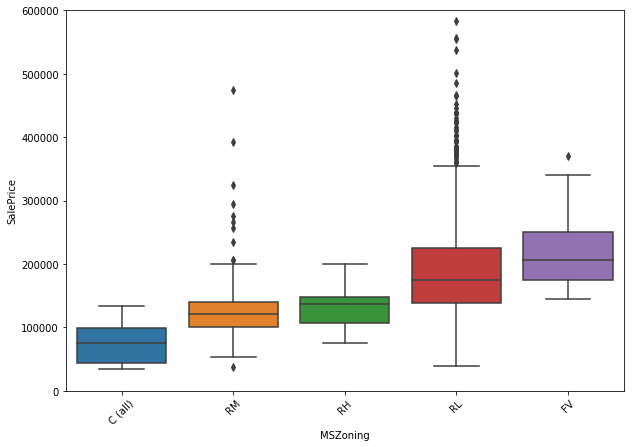

In [37]:
#--Plot MSZoning to relevel
order_index = pd.DataFrame(train_shifted.groupby(['MSZoning']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.MSZoning, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (RM-RH). We'll change to the mode between the two groups.

In [38]:
train_shifted['MSZoning'] = train_shifted.MSZoning.replace({'RH' : 'RM'})
test_shifted['MSZoning'] = test_shifted.MSZoning.replace({'RH' : 'RM'})

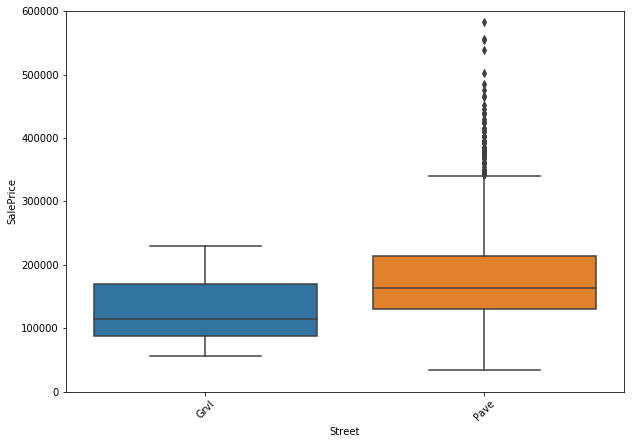

In [39]:
#--Plot Street to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Street']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Street, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Street feature.

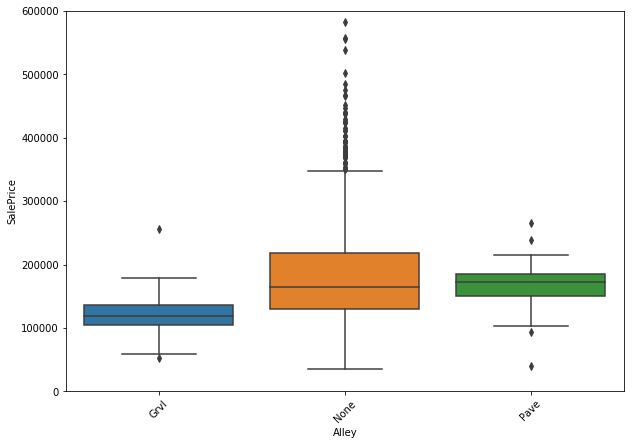

In [40]:
#--Plot Alley to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Alley']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Alley, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Alley feature.

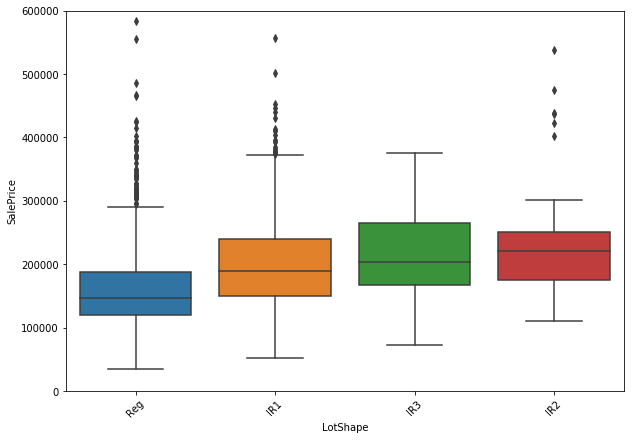

In [41]:
#--Plot LotShape to relevel
order_index = pd.DataFrame(train_shifted.groupby(['LotShape']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.LotShape, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the LotShape feature.

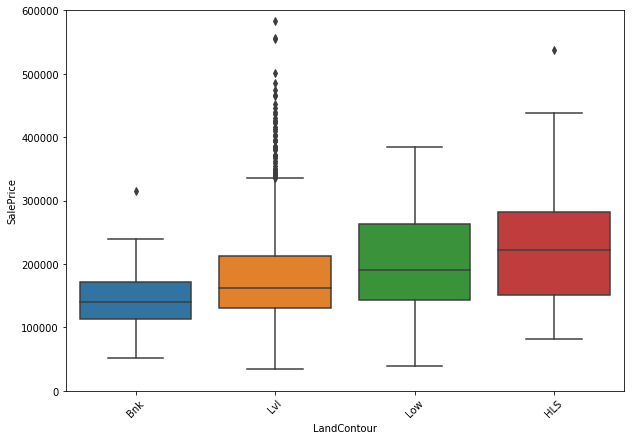

In [42]:
#--Plot LandContour to relevel
order_index = pd.DataFrame(train_shifted.groupby(['LandContour']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.LandContour, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the LandContour feature.

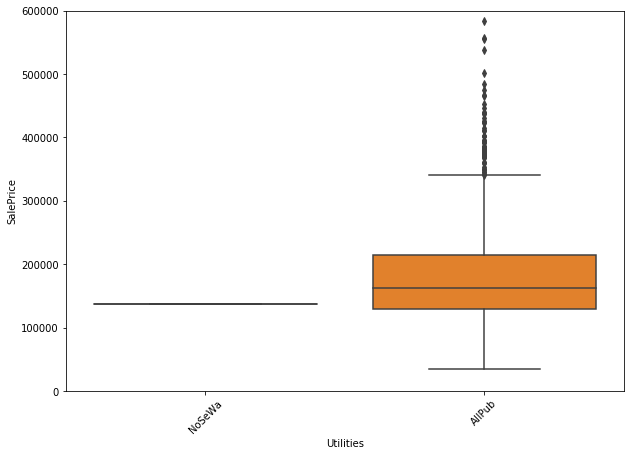

In [43]:
#--Plot Utilities to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Utilities']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Utilities, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we can drop the Utilities feature as there isn't a significant variance in the test dataset either.

In [44]:
train_shifted = train_shifted.drop('Utilities', 1)
test_shifted = test_shifted.drop('Utilities', 1)

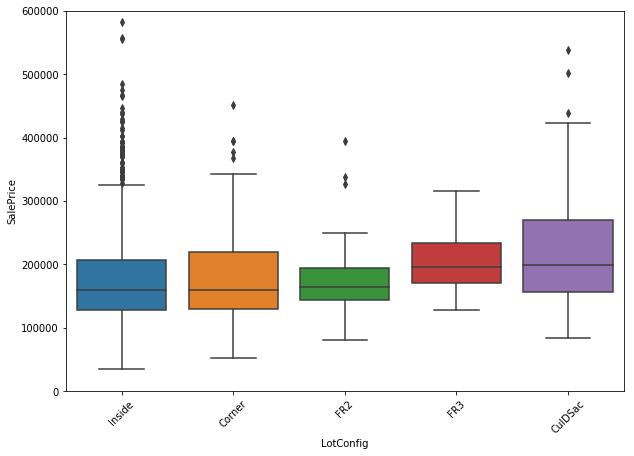

In [45]:
#--Plot LotConfig to relevel
order_index = pd.DataFrame(train_shifted.groupby(['LotConfig']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.LotConfig, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Inside-Corner). We'll change to the mode between the two groups.

In [46]:
train_shifted['LotConfig'] = train_shifted.LotConfig.replace({'Corner' : 'Inside'})
test_shifted['LotConfig'] = test_shifted.LotConfig.replace({'Corner' : 'Inside'})

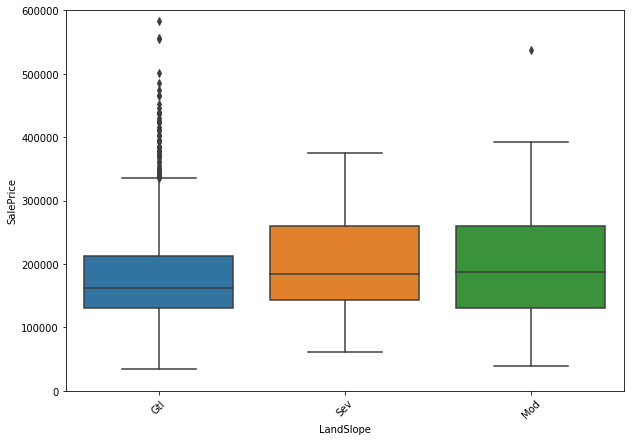

In [47]:
#--Plot LandSlope to relevel
order_index = pd.DataFrame(train_shifted.groupby(['LandSlope']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.LandSlope, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Sev-Mod). We'll change to the mode between the two groups.

In [48]:
train_shifted['LandSlope'] = train_shifted.LandSlope.replace({'Sev' : 'Mod'})
test_shifted['LandSlope'] = test_shifted.LandSlope.replace({'Sev' : 'Mod'})

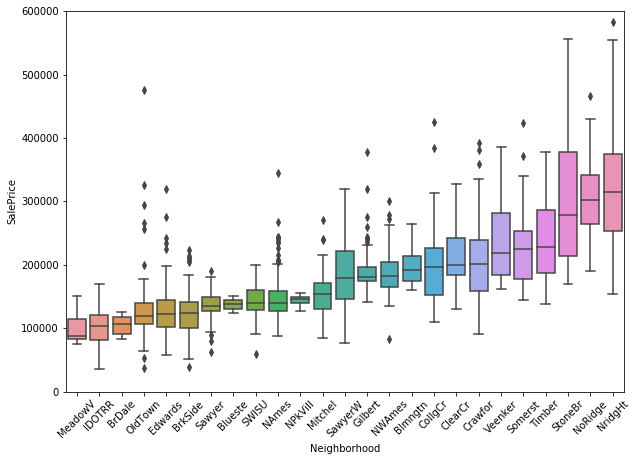

In [49]:
#--Plot Neighborhood to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Neighborhood']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Neighborhood, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (OldTown-Edwards-BrkSide), (SWISU-NAmes) and (CollgCr-ClearCr-Crawfor). We'll change to the mode between the groups.

In [50]:
train_shifted['Neighborhood'] = train_shifted.Neighborhood.replace({'Edwards' : 'OldTown', 'BrkSide':'OldTown', 'SWISU':'NAmes', 'ClearCr':'CollgCr','Crawfor':'CollgCr'})
test_shifted['Neighborhood'] = test_shifted.Neighborhood.replace({'Edwards' : 'OldTown', 'BrkSide':'OldTown', 'SWISU':'NAmes', 'ClearCr':'CollgCr','Crawfor':'CollgCr'})

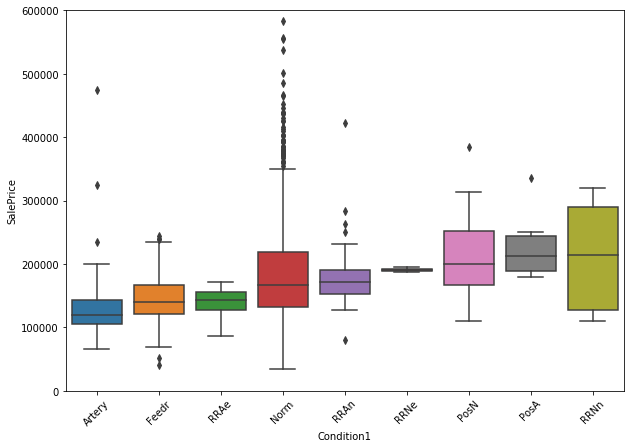

In [51]:
#--Plot Condition1 to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Condition1']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Condition1, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Condition1 feature.

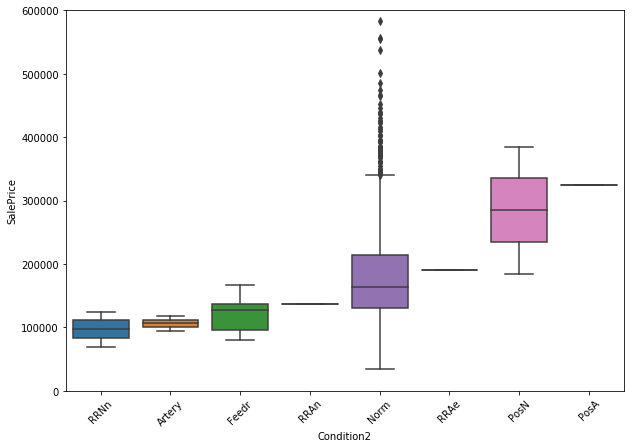

In [52]:
#--Plot Condition2 to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Condition2']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Condition2, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Condition2 feature.

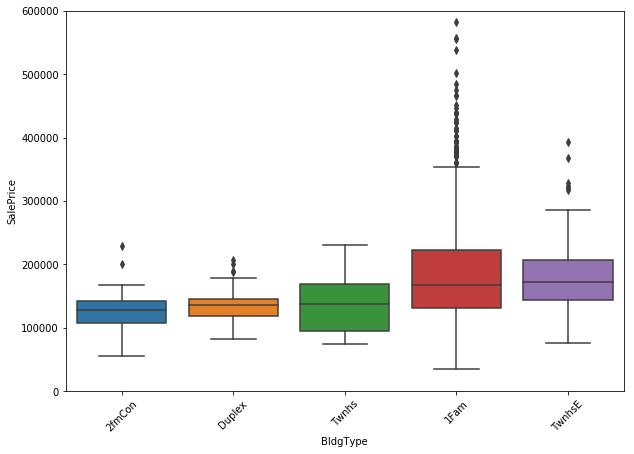

In [53]:
#--Plot BldgType to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BldgType']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BldgType, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (2fmCon-Duplex). We'll change to the mode between the groups.

In [54]:
train_shifted['BldgType'] = train_shifted.BldgType.replace({'2fmCon' : 'Duplex'})
test_shifted['BldgType'] = test_shifted.BldgType.replace({'2fmCon' : 'Duplex'})

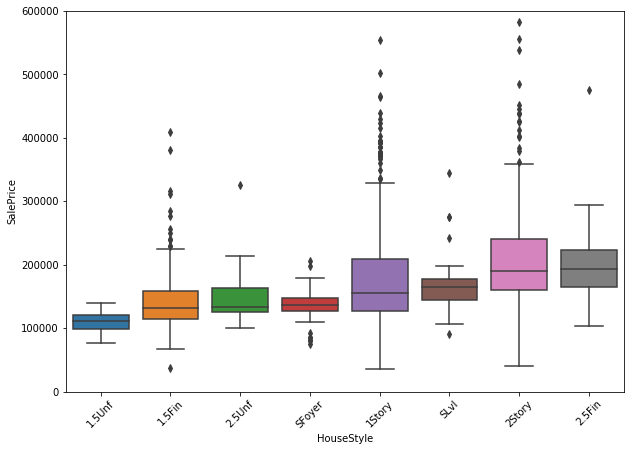

In [55]:
#--Plot HouseStyle to relevel
order_index = pd.DataFrame(train_shifted.groupby(['HouseStyle']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.HouseStyle, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (SFoyer-SLvl). We'll change to the mode between the groups.

In [56]:
train_shifted['HouseStyle'] = train_shifted.HouseStyle.replace({'SFoyer' : 'SLvl'})
test_shifted['HouseStyle'] = test_shifted.HouseStyle.replace({'SFoyer' : 'SLvl'})

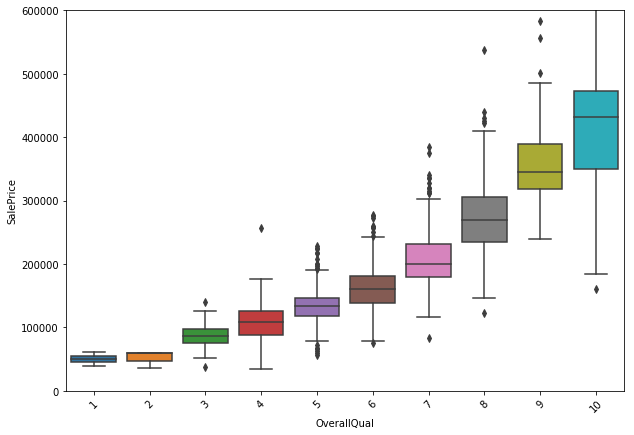

In [57]:
#--Plot OverallQual to relevel
order_index = pd.DataFrame(train_shifted.groupby(['OverallQual']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.OverallQual, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the OverallQual feature.

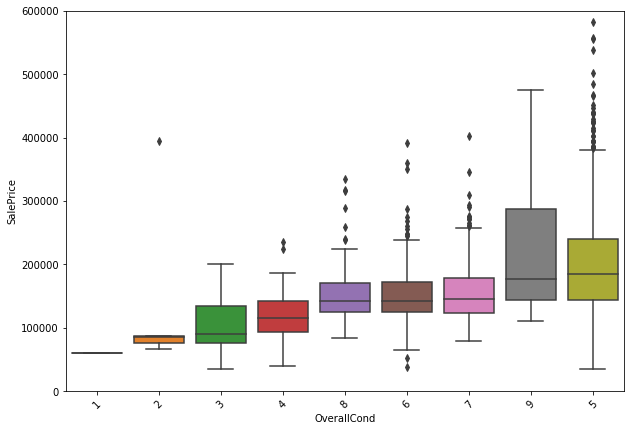

In [58]:
#--Plot OverallCond to relevel
order_index = pd.DataFrame(train_shifted.groupby(['OverallCond']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.OverallCond, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the OverallCond feature.

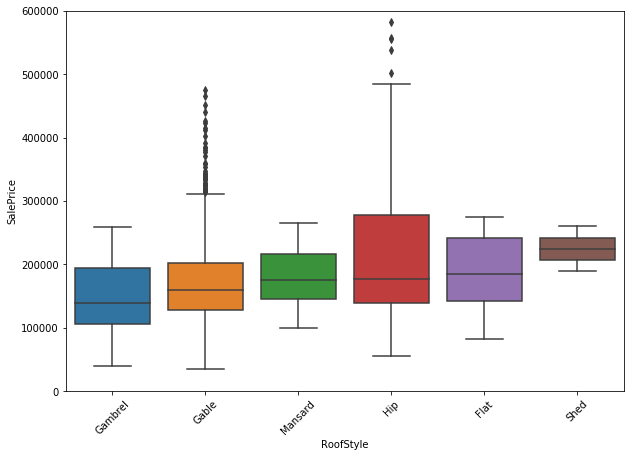

In [59]:
#--Plot RoofStyle to relevel
order_index = pd.DataFrame(train_shifted.groupby(['RoofStyle']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.RoofStyle, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Mansard-Flat). We'll change to the mode between the groups.

In [60]:
train_shifted['RoofStyle'] = train_shifted.RoofStyle.replace({'Mansard' : 'Flat'})
test_shifted['RoofStyle'] = test_shifted.RoofStyle.replace({'Mansard' : 'Flat'})

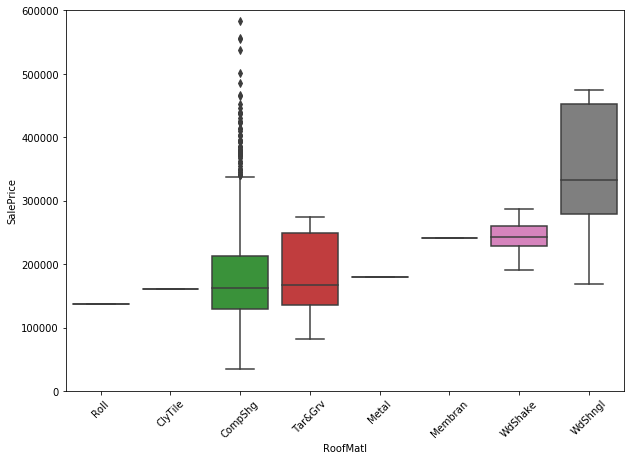

In [61]:
#--Plot RoofMatl to relevel
order_index = pd.DataFrame(train_shifted.groupby(['RoofMatl']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.RoofMatl, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the RoofMatl feature.

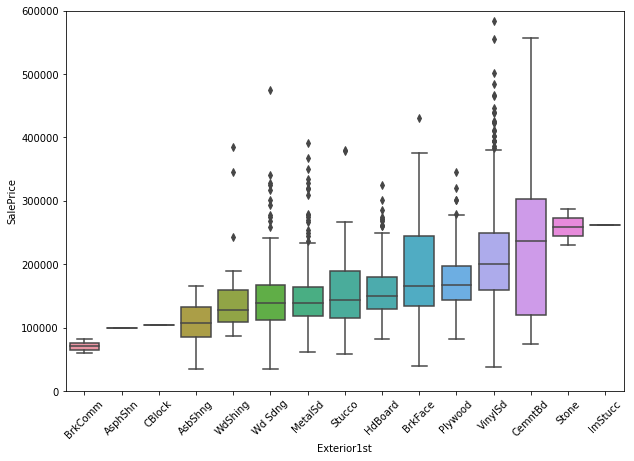

In [62]:
#--Plot Exterior1st to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Exterior1st']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Exterior1st, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (MetalSd-HdBoard) and (Stucco-Plywood). We'll change to the mode between the groups.

In [63]:
train_shifted['Exterior1st'] = train_shifted.Exterior1st.replace({'MetalSd' : 'HdBoard','Stucco' : 'Plywood'})
test_shifted['Exterior1st'] = test_shifted.Exterior1st.replace({'MetalSd' : 'HdBoard','Stucco' : 'Plywood'})

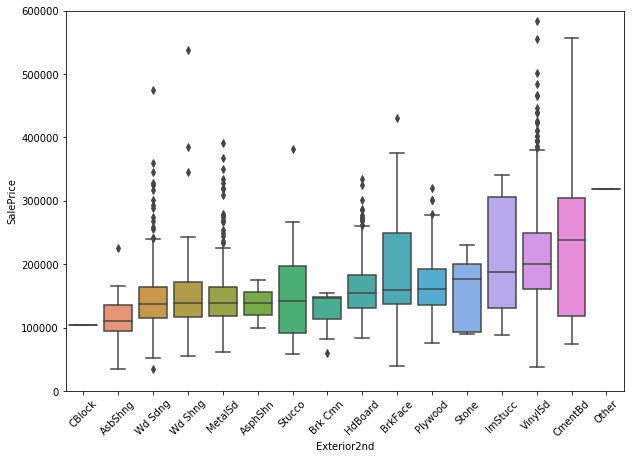

In [64]:
#--Plot Exterior2nd to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Exterior2nd']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Exterior2nd, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

To be aligned with the Exterior1st releveling, we will apply the same changes to Exterior2nd.

In [65]:
train_shifted['Exterior2nd'] = train_shifted.Exterior2nd.replace({'MetalSd' : 'HdBoard','Stucco' : 'Plywood'})
test_shifted['Exterior2nd'] = test_shifted.Exterior2nd.replace({'MetalSd' : 'HdBoard','Stucco' : 'Plywood'})

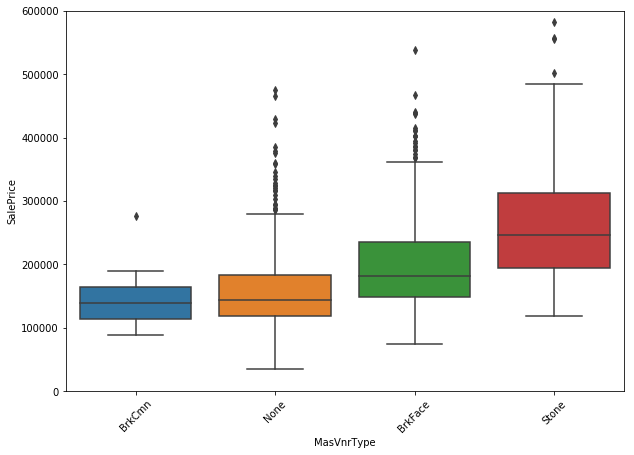

In [66]:
#--Plot MasVnrType to relevel
order_index = pd.DataFrame(train_shifted.groupby(['MasVnrType']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.MasVnrType, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the MasVnrType feature.

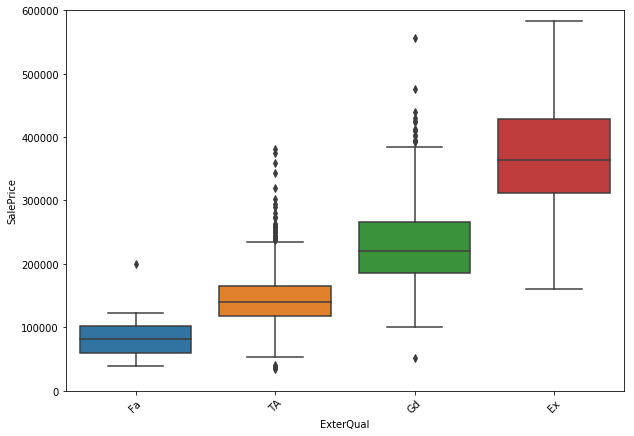

In [67]:
#--Plot ExterQual to relevel
order_index = pd.DataFrame(train_shifted.groupby(['ExterQual']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.ExterQual, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the ExterQual feature.

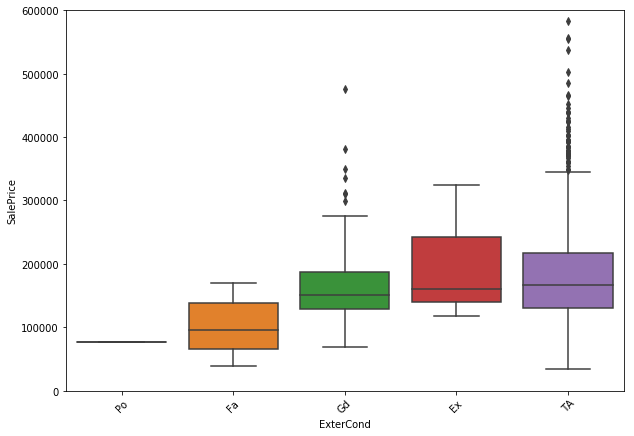

In [68]:
#--Plot ExterCond to relevel
order_index = pd.DataFrame(train_shifted.groupby(['ExterCond']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.ExterCond, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the ExterCond feature.

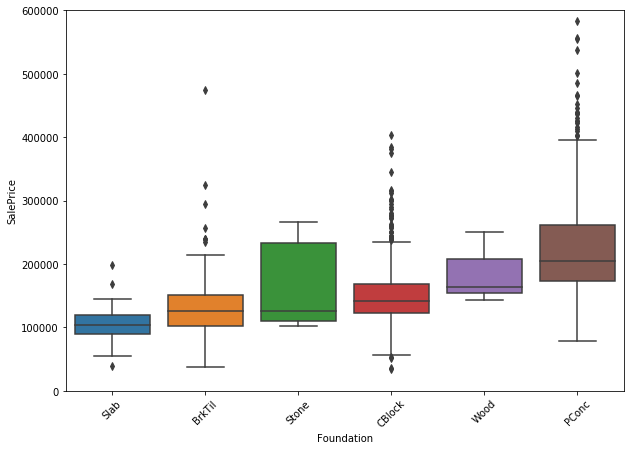

In [69]:
#--Plot Foundation to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Foundation']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Foundation, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (BrkTil-CBlock). We'll change to the mode between the groups.

In [70]:
train_shifted['Foundation'] = train_shifted.Foundation.replace({'BrkTil' : 'CBlock'})
test_shifted['Foundation'] = test_shifted.Foundation.replace({'BrkTil' : 'CBlock'})

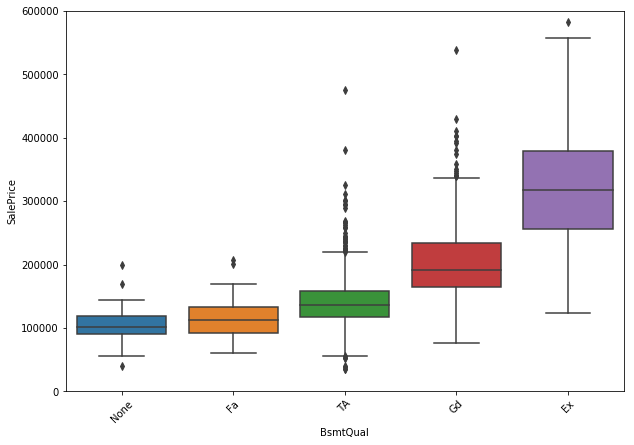

In [71]:
#--Plot BsmtQual to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BsmtQual']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BsmtQual, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the BsmtQual feature.

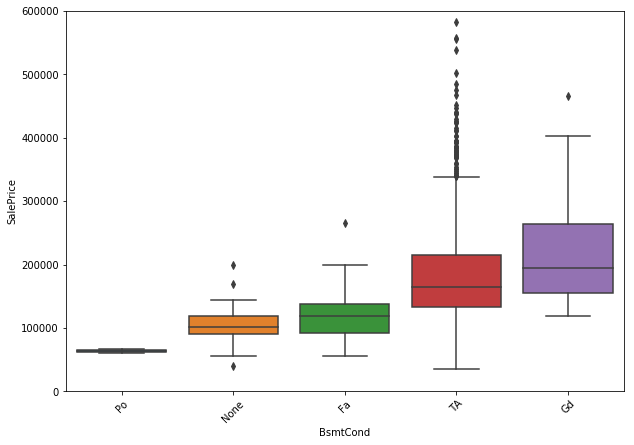

In [72]:
#--Plot BsmtCond to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BsmtCond']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BsmtCond, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the BsmtCond feature.

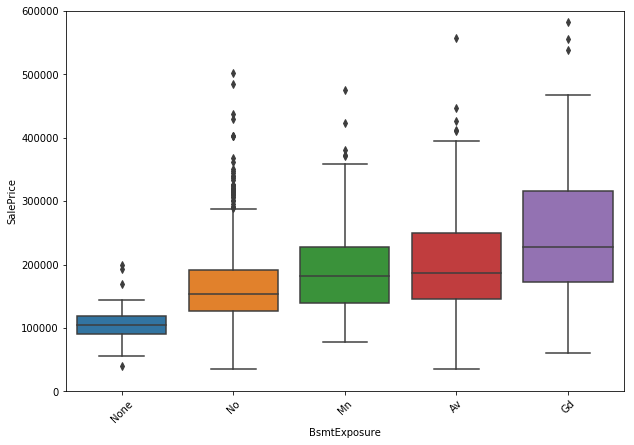

In [73]:
#--Plot BsmtExposure to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BsmtExposure']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BsmtExposure, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the BsmtExposure feature.

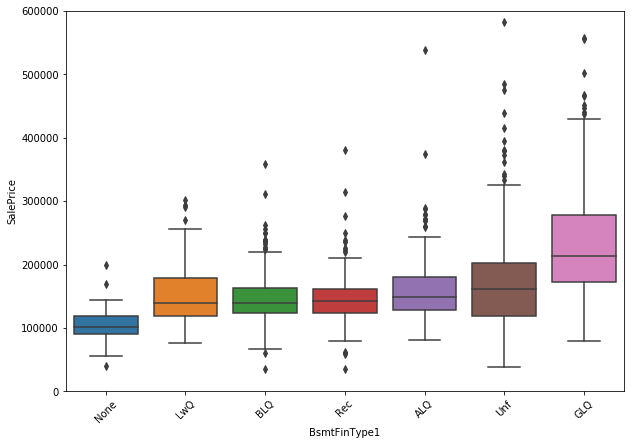

In [74]:
#--Plot BsmtFinType1 to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BsmtFinType1']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BsmtFinType1, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (LwQ-BLQ-Rec). We'll change to the mode between the groups.

In [75]:
train_shifted['BsmtFinType1'] = train_shifted.BsmtFinType1.replace({'LwQ' : 'BLQ','Rec' : 'BLQ'})
test_shifted['BsmtFinType1'] = test_shifted.BsmtFinType1.replace({'LwQ' : 'BLQ','Rec' : 'BLQ'})

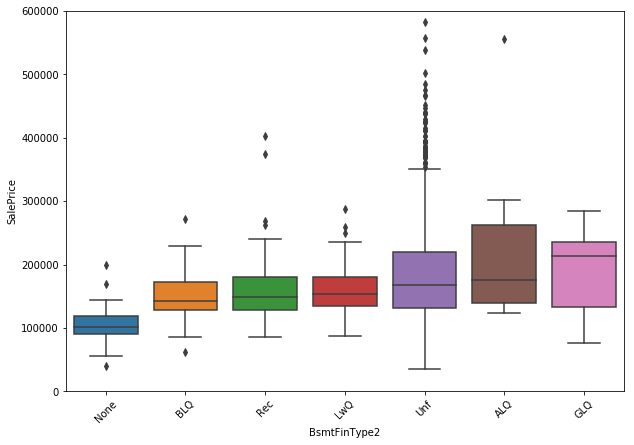

In [76]:
#--Plot BsmtFinType2 to relevel
order_index = pd.DataFrame(train_shifted.groupby(['BsmtFinType2']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.BsmtFinType2, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

We'll use the same modifications as we did for BsmtFinType1.

In [77]:
train_shifted['BsmtFinType2'] = train_shifted.BsmtFinType2.replace({'LwQ' : 'BLQ','Rec' : 'BLQ'})
test_shifted['BsmtFinType2'] = test_shifted.BsmtFinType2.replace({'LwQ' : 'BLQ','Rec' : 'BLQ'})

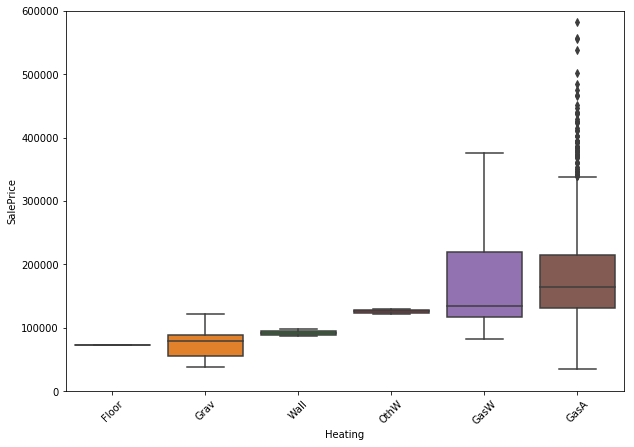

In [78]:
#--Plot Heating to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Heating']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Heating, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Heating feature.

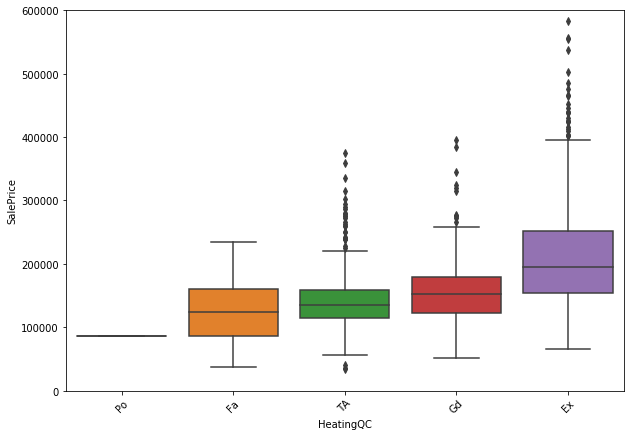

In [79]:
#--Plot HeatingQC to relevel
order_index = pd.DataFrame(train_shifted.groupby(['HeatingQC']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.HeatingQC, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Fa-TA-Gd). We'll change to TA (middle).

In [80]:
train_shifted['HeatingQC'] = train_shifted.HeatingQC.replace({'Fa' : 'TA','Gd' : 'TA'})
test_shifted['HeatingQC'] = test_shifted.HeatingQC.replace({'Fa' : 'TA','Gd' : 'TA'})

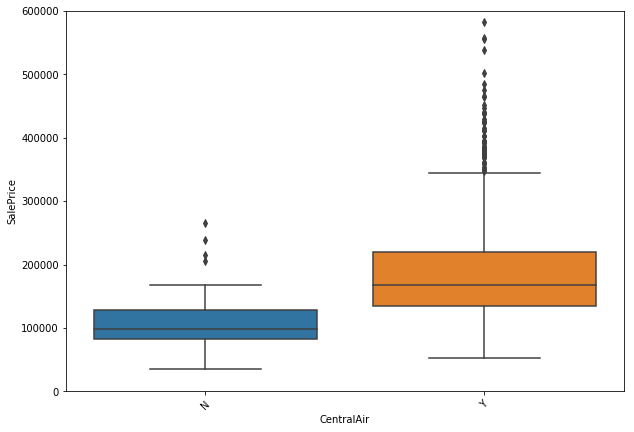

In [81]:
#--Plot CentralAir to relevel
order_index = pd.DataFrame(train_shifted.groupby(['CentralAir']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.CentralAir, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the CentralAir feature.

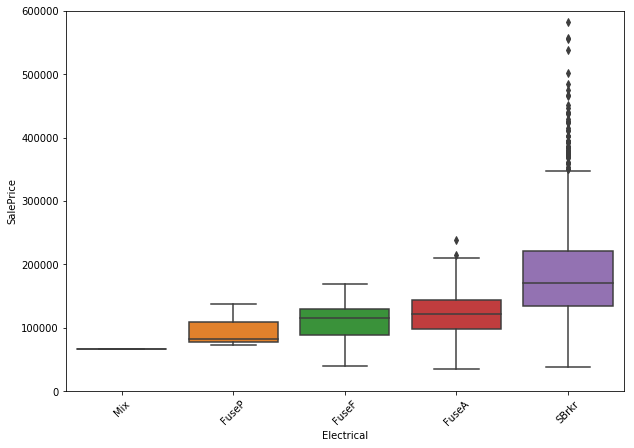

In [82]:
#--Plot Electrical to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Electrical']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Electrical, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (FuseF-FuseA). We'll change to the mode of the group.

In [83]:
train_shifted['Electrical'] = train_shifted.Electrical.replace({'FuseF' : 'FuseA'})
test_shifted['Electrical'] = test_shifted.Electrical.replace({'FuseF' : 'FuseA'})

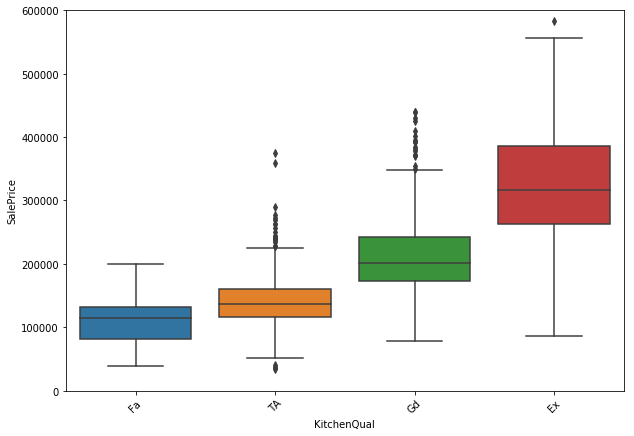

In [84]:
#--Plot KitchenQual to relevel
order_index = pd.DataFrame(train_shifted.groupby(['KitchenQual']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.KitchenQual, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Fa-TA). We'll change to the mode of the group.

In [85]:
train_shifted['KitchenQual'] = train_shifted.KitchenQual.replace({'Fa' : 'TA'})
test_shifted['KitchenQual'] = test_shifted.KitchenQual.replace({'Fa' : 'TA'})

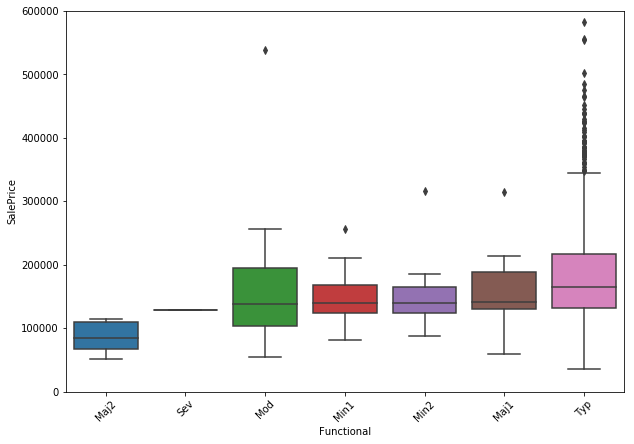

In [86]:
#--Plot Functional to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Functional']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Functional, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Mod-Min1-Min2-Maj1). We'll change to the mode of the group.

In [87]:
train_shifted['Functional'] = train_shifted.Functional.replace({'Mod' : 'Min2','Min1' : 'Min2','Maj1' : 'Min2'})
test_shifted['Functional'] = test_shifted.Functional.replace({'Mod' : 'Min2','Min1' : 'Min2','Maj1' : 'Min2'})

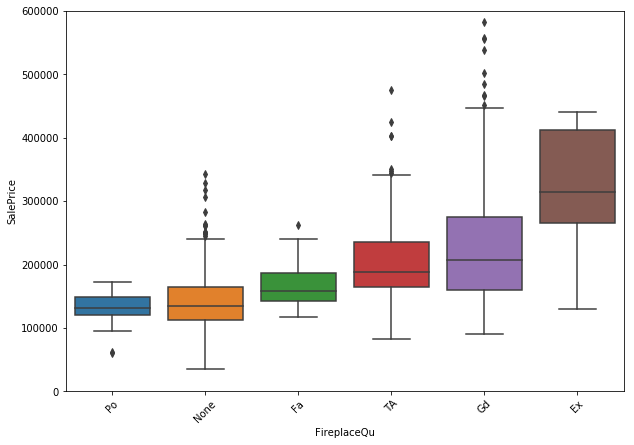

In [88]:
#--Plot FireplaceQu to relevel
order_index = pd.DataFrame(train_shifted.groupby(['FireplaceQu']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.FireplaceQu, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the FireplaceQu feature.

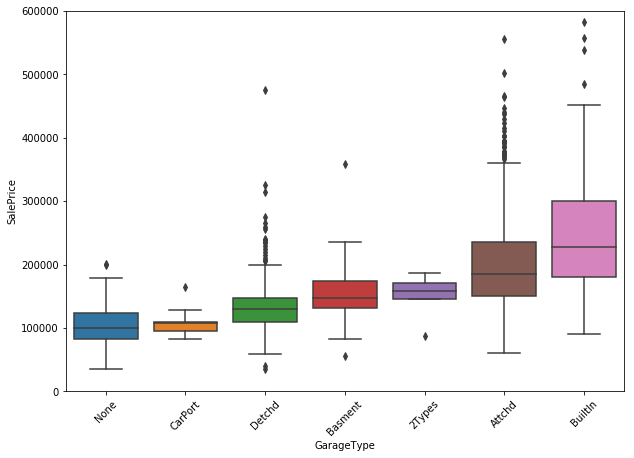

In [89]:
#--Plot GarageType to relevel
order_index = pd.DataFrame(train_shifted.groupby(['GarageType']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.GarageType, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the GarageType feature.

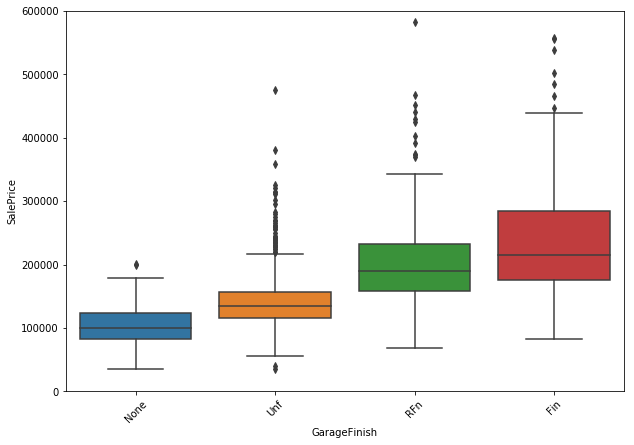

In [90]:
#--Plot GarageFinish to relevel
order_index = pd.DataFrame(train_shifted.groupby(['GarageFinish']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.GarageFinish, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the GarageFinish feature.

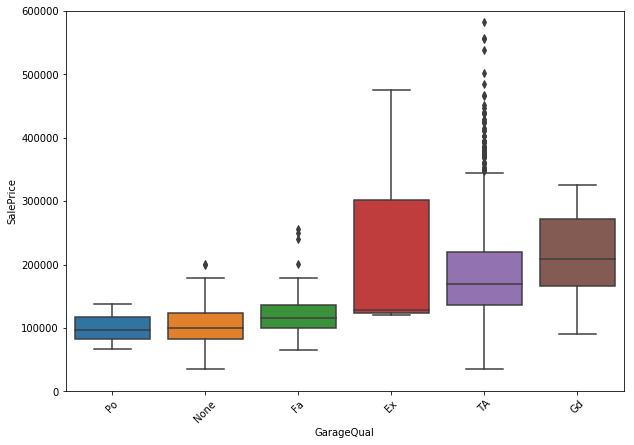

In [91]:
#--Plot GarageQual to relevel
order_index = pd.DataFrame(train_shifted.groupby(['GarageQual']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.GarageQual, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Po-None-Fa). We'll change to Fa.

In [92]:
train_shifted['GarageQual'] = train_shifted.GarageQual.replace({'Po' : 'Fa','None' : 'Fa'})
test_shifted['GarageQual'] = test_shifted.GarageQual.replace({'Po' : 'Fa','None' : 'Fa'})

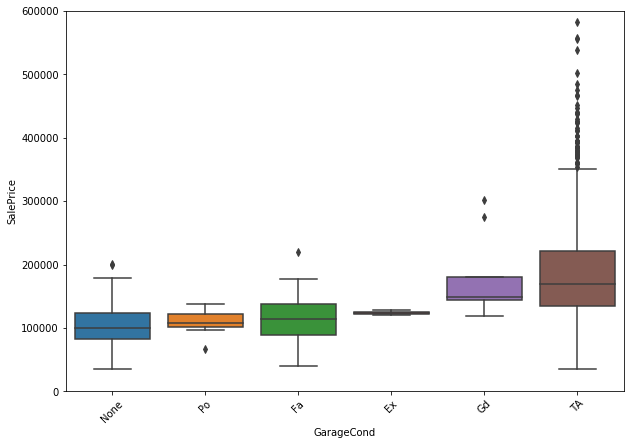

In [93]:
#--Plot GarageCond to relevel
order_index = pd.DataFrame(train_shifted.groupby(['GarageCond']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.GarageCond, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Po-None-Fa). We'll change to Fa.

In [94]:
train_shifted['GarageCond'] = train_shifted.GarageCond.replace({'Po' : 'Fa','None' : 'Fa'})
test_shifted['GarageCond'] = test_shifted.GarageCond.replace({'Po' : 'Fa','None' : 'Fa'})

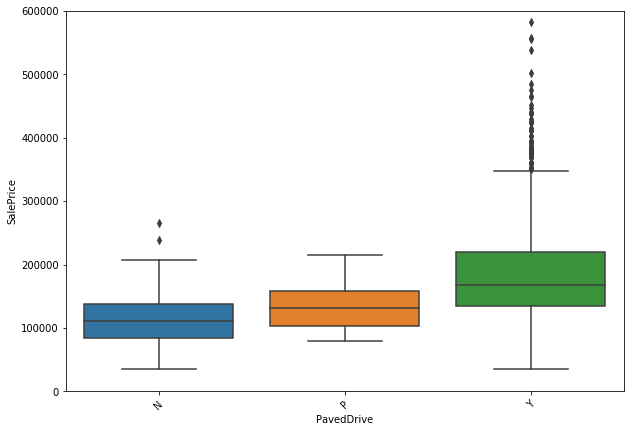

In [95]:
#--Plot PavedDrive to relevel
order_index = pd.DataFrame(train_shifted.groupby(['PavedDrive']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.PavedDrive, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (N-P). We'll change to the mode of the group.

In [96]:
train_shifted['PavedDrive'] = train_shifted.PavedDrive.replace({'P' : 'N'})
test_shifted['PavedDrive'] = test_shifted.PavedDrive.replace({'P' : 'N'})

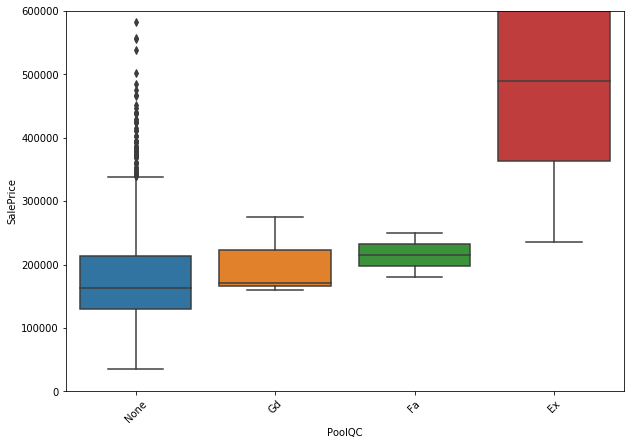

In [97]:
#--Plot PoolQC to relevel
order_index = pd.DataFrame(train_shifted.groupby(['PoolQC']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.PoolQC, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the PoolQC feature.

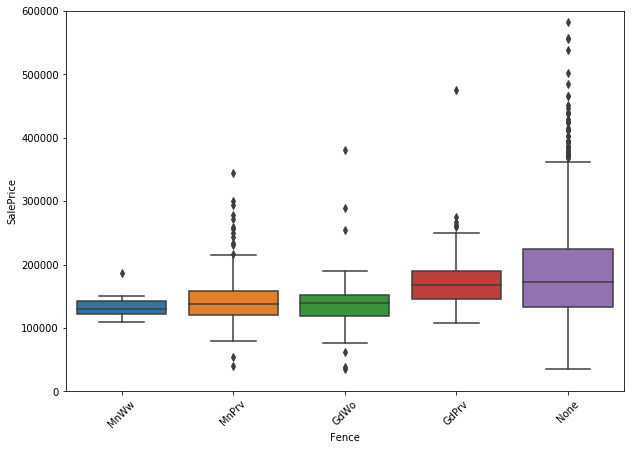

In [98]:
#--Plot Fence to relevel
order_index = pd.DataFrame(train_shifted.groupby(['Fence']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.Fence, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the Fence feature.

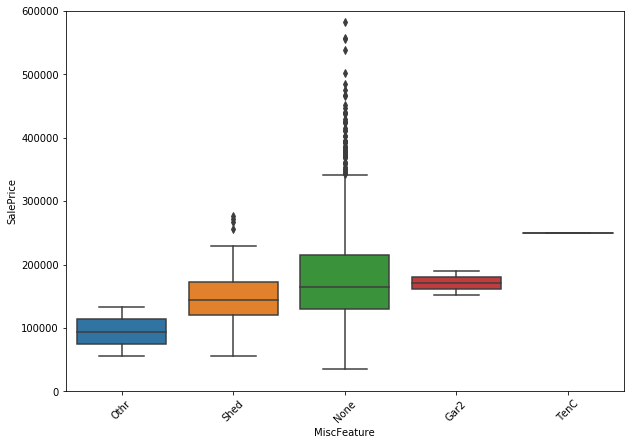

In [99]:
#--Plot MiscFeature to relevel
order_index = pd.DataFrame(train_shifted.groupby(['MiscFeature']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.MiscFeature, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, we will not relevel the MiscFeature feature.

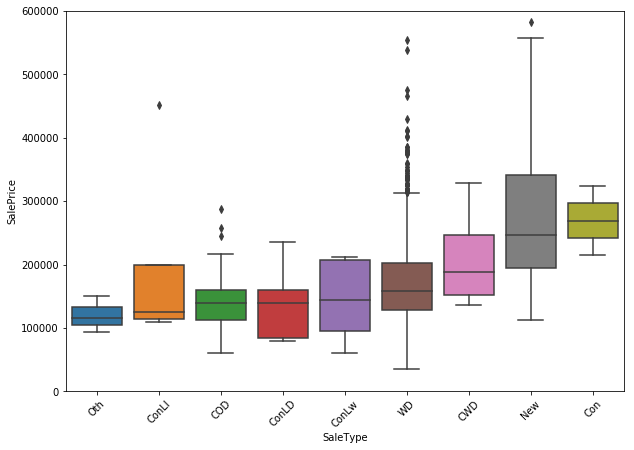

In [100]:
#--Plot SaleType to relevel
order_index = pd.DataFrame(train_shifted.groupby(['SaleType']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.SaleType, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Oth-ConLI-COD-ConLD-ConLW). We'll change to the mode of the group.

In [101]:
train_shifted['SaleType'] = train_shifted.SaleType.replace({'Oth' : 'COD','ConLI' : 'COD','ConLD' : 'COD','ConLw' : 'COD'})
test_shifted['SaleType'] = test_shifted.SaleType.replace({'Oth' : 'COD','ConLI' : 'COD','ConLD' : 'COD','ConLw' : 'COD'})

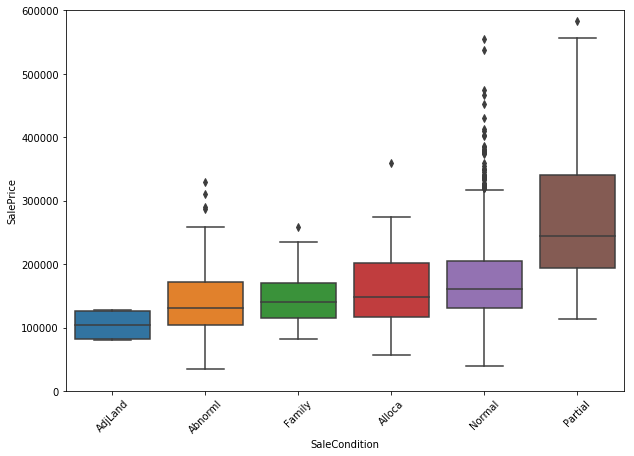

In [102]:
#--Plot SaleCondition to relevel
order_index = pd.DataFrame(train_shifted.groupby(['SaleCondition']).median()).sort_values(by=['SalePrice']).index.tolist()

fig = plt.figure(figsize=(10, 7))
sns.boxplot(y=Y_train, x=X_train.SaleCondition, order = order_index)
plt.ylim([0,600000])
plt.xticks(rotation=45)
plt.show()

From the graph above, for the train and test datasets, we can group (Abnorml-Family-Alloca). We'll change to the mode of the group.

In [103]:
train_shifted['SaleCondition'] = train_shifted.SaleCondition.replace({'Family' : 'Abnorml','Alloca' : 'Abnorml'})
test_shifted['SaleCondition'] = test_shifted.SaleCondition.replace({'Family' : 'Abnorml','Alloca' : 'Abnorml'})

Next, we can create a plot of *SALEPRICE* versus *GRLIVAREA* to identify any outliers. *GRLIVAREA* is a numerical predictor that is highly correlated with the response. Based on the plot, there are 4 obvious outliers which have an above grade (ground) living area square feet greater than 4000.

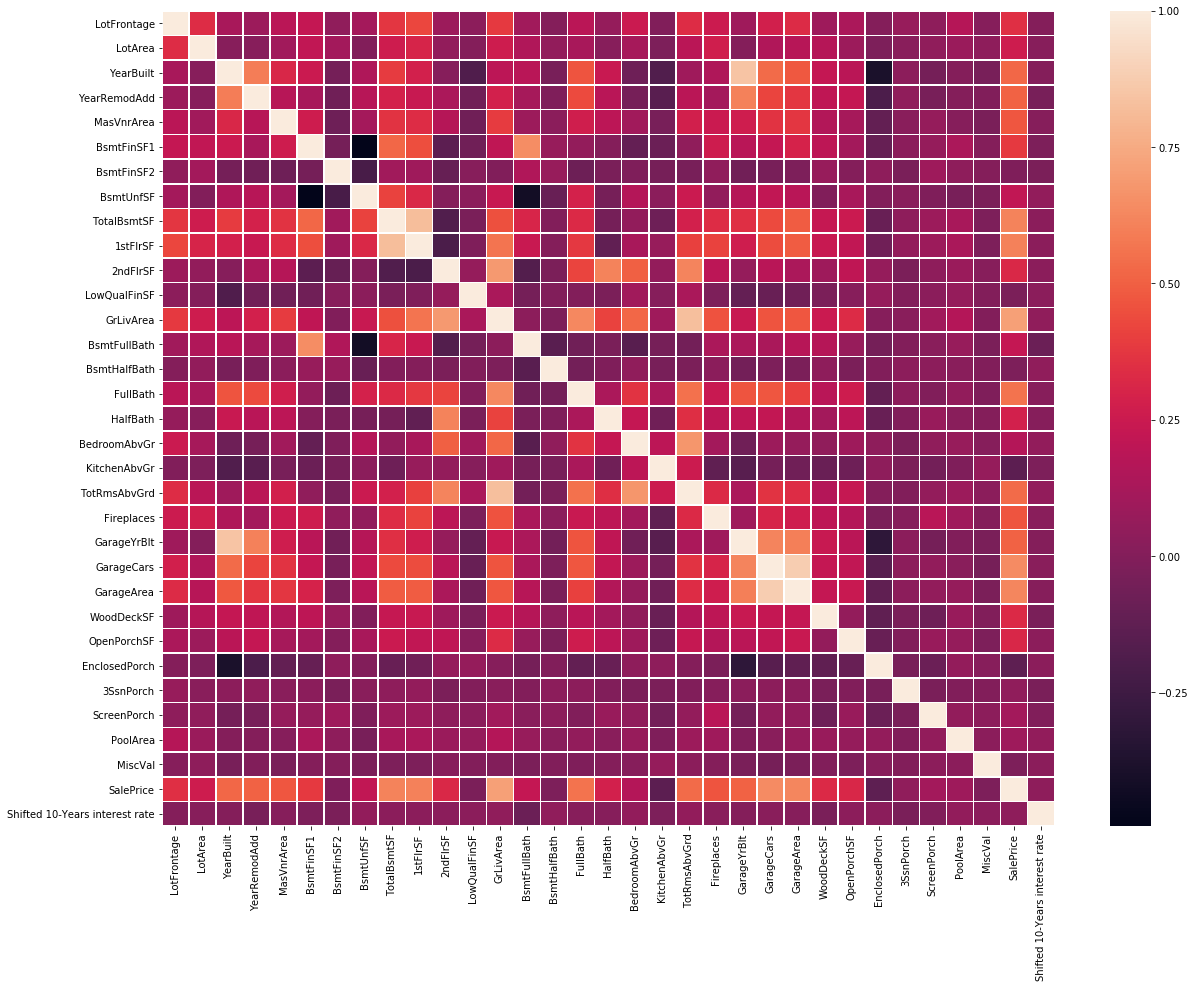

In [104]:
corr = train_shifted.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,linewidths=0.5)
plt.show()

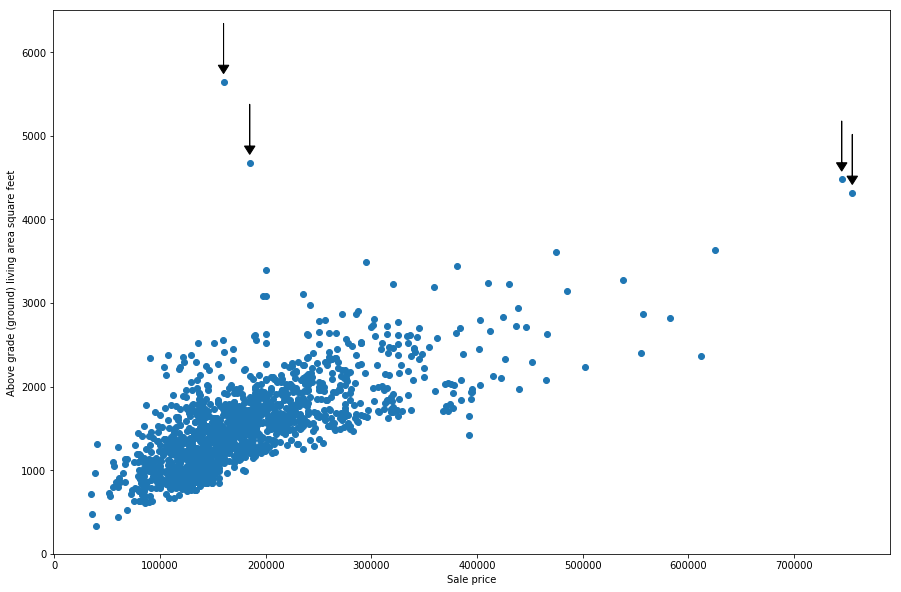

In [105]:
X_train_shifted = train_shifted.drop('SalePrice', 1)
Y_train_shifted = pd.Series(train_shifted['SalePrice'])

plt.figure(figsize=(15,10))
plt.scatter(Y_train_shifted, X_train_shifted['GrLivArea'])
plt.xlabel('Sale price')
plt.ylabel('Above grade (ground) living area square feet')

axes = plt.gca()
axes.set_ylim([0,6500])


P.arrow(184750, 5376, 0.0, -500, fc="k", ec="k",head_width=10000, head_length=100 )
P.arrow(755000, 5016, 0.0, -500, fc="k", ec="k",head_width=10000, head_length=100 )
P.arrow(745000, 5176, 0.0, -500, fc="k", ec="k",head_width=10000, head_length=100 )
P.arrow(160000, 6342, 0.0, -500, fc="k", ec="k",head_width=10000, head_length=100 )
plt.show()
P.show()

In [106]:
##--Drop outliers with ground living area greater than 4000 sq feet.
train_shifted = train_shifted[train_shifted['GrLivArea']<=4000]

As the response variable, *Sale Price*, is continuous, we'll utilize regression models. One assumption of linear regression models is that the error between the observed and expected values (i.e., the residuals) should be normally distributed. Violations of this assumption often stem from a skewed response variable. Because Sale Price has a right skew, we'll log + 1 transform to normalize its distribution. The "+ 1" is to prevent from getting errors on cells containing value 0.

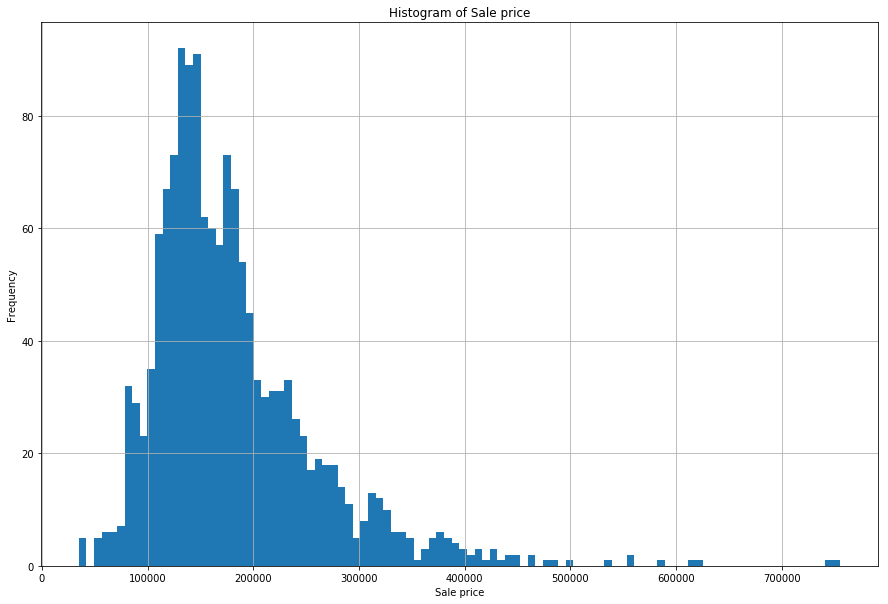

In [107]:
##--Plot SalePrice prior to transformation
fig = plt.figure(figsize=(15,10))
plt.ylabel('Frequency')
plt.xlabel('Sale price',)
plt.title('Histogram of Sale price')
Y_train_shifted.hist(bins=100)
plt.show()

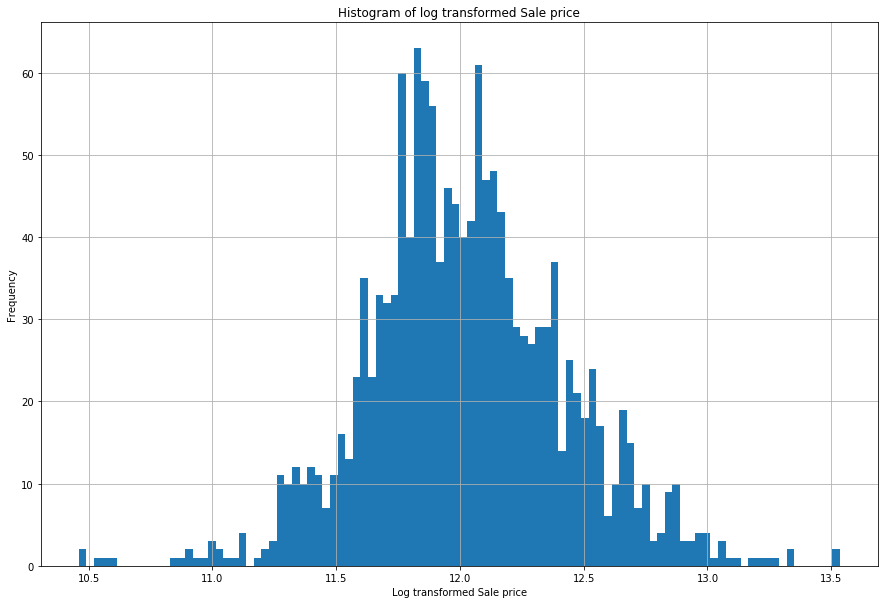

In [108]:
##--Plot SalePrice post transformation
Y_train_log_shifted = Y_train_shifted.apply(lambda x: np.log(x + 1))
fig = plt.figure(figsize=(15,10))
plt.ylabel('Frequency')
plt.xlabel('Log transformed Sale price',)
plt.title('Histogram of log transformed Sale price')
Y_train_log_shifted.hist(bins=100)
plt.show()

In [109]:
#--Log transform the SalePrice
train_shifted["LogSalePrice"] = np.log1p(train_shifted["SalePrice"])
train_shifted.drop(['SalePrice'], axis=1, inplace=True)

X_train_shifted = train_shifted.drop('LogSalePrice', 1)
Y_train_shifted = train_shifted.LogSalePrice.values
train_shifted.drop(['LogSalePrice'], axis=1, inplace=True)

**Box Cox Transformation for skewed features**

In [110]:
#--Finding list of numerical data
num_list = train_shifted.loc[:, train_shifted.dtypes != object].columns

# Check the skew of all numerical features
skewed_feats = train_shifted[num_list].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)

,Skew
MiscVal,24.418175
PoolArea,17.504556
LotArea,12.574590
3SsnPorch,10.279262
LowQualFinSF,8.989291
KitchenAbvGr,4.476748
BsmtFinSF2,4.244209
BsmtHalfBath,4.124712
ScreenPorch,4.111400
EnclosedPorch,3.081275


In [111]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} features to Box Cox Transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.12 #lam = lambda
for feat in skewed_features:
    train_shifted[feat] = boxcox1p(train_shifted[feat], lam)

There are 32 features to Box Cox Transform


In [112]:
#--Finding list of numerical data
num_list = test_shifted.loc[:, test_shifted.dtypes != object].columns

# Check the skew of all numerical features
skewed_feats = test_shifted[num_list].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)

,Skew
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
3SsnPorch,12.511336
EnclosedPorch,4.664371
KitchenAbvGr,4.074860
BsmtFinSF2,4.038796
ScreenPorch,3.784349
BsmtHalfBath,3.779085
LotArea,3.112013


In [113]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} features to Box Cox Transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.12 #lam = lambda
for feat in skewed_features:
    test_shifted[feat] = boxcox1p(test_shifted[feat], lam)

There are 32 features to Box Cox Transform


I will use pandas.get_dummies() function to convert categorical variables in both train and test datasets.

In [114]:
train_shifted.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,Shifted 10-Years interest rate
0,60,RL,5.443964,16.329770,Pave,None,Reg,Lvl,Inside,Gtl,...,0.0,0.0,None,None,None,0.0,2,WD,Normal,1.768553
1,20,RL,5.786740,16.710265,Pave,None,Reg,Lvl,FR2,Gtl,...,0.0,0.0,None,None,None,0.0,5,WD,Normal,1.902752
2,60,RL,5.517651,17.191428,Pave,None,IR1,Lvl,Inside,Gtl,...,0.0,0.0,None,None,None,0.0,9,WD,Normal,1.770259
3,70,RL,5.314331,16.694578,Pave,None,IR1,Lvl,Inside,Gtl,...,0.0,0.0,None,None,None,0.0,2,WD,Abnorml,1.891642
4,60,RL,5.868651,17.927999,Pave,None,IR1,Lvl,FR2,Gtl,...,0.0,0.0,None,None,None,0.0,12,WD,Normal,1.732739


In [115]:
print("Train set shape before One Hot Encoding: (%d,%d)" %train_shifted.shape)
train_shifted = pd.get_dummies(train_shifted, drop_first=True)
print("\nTrain set shape after One Hot Encoding: (%d,%d)" %train_shifted.shape)
train_shifted.head()

Train set shape before One Hot Encoding: (1456,78)

Train set shape after One Hot Encoding: (1456,255)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_7,MoSold_8,MoSold_9,SaleType_CWD,SaleType_Con,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
0,5.443964,16.329770,12.418023,12.418023,7.375890,9.979228,0.0,6.882509,10.406963,10.406963,...,0,0,0,0,0,0,1,0,1,0
1,5.786740,16.710265,12.384272,12.384272,0.000000,10.708672,0.0,8.087687,11.299689,11.299689,...,0,0,0,0,0,0,1,0,1,0
2,5.517651,17.191428,12.415536,12.416780,7.022779,9.178122,0.0,8.942439,10.569631,10.569631,...,0,0,1,0,0,0,1,0,1,0
3,5.314331,16.694578,12.306501,12.376717,0.000000,7.559229,0.0,9.400492,10.130006,10.668686,...,0,0,0,0,0,0,1,0,0,0
4,5.868651,17.927999,12.414292,12.414292,8.503314,9.815437,0.0,9.195319,11.071991,11.071991,...,0,0,0,0,0,0,1,0,1,0


In [116]:
print("Test set shape before One Hot Encoding: (%d,%d)" %test_shifted.shape)
test_shifted = pd.get_dummies(test_shifted, drop_first=True)
print("\nTest set shape after One Hot Encoding: (%d,%d)" %test_shifted.shape)
test_shifted.head()

Test set shape before One Hot Encoding: (1459,78)

Test set shape after One Hot Encoding: (1459,240)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_7,MoSold_8,MoSold_9,SaleType_CWD,SaleType_Con,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
0,5.786740,17.291258,12.365346,12.365346,0.000000,9.099159,6.808655,7.988730,10.474295,10.509831,...,0,0,0,0,0,0,1,0,1,0
1,5.807546,17.929545,12.361545,12.361545,6.298877,10.577009,0.000000,8.805059,11.421845,11.421845,...,0,0,0,0,0,0,1,0,1,0
2,5.656937,17.831693,12.410557,12.411803,0.000000,10.230419,0.000000,6.719014,10.589259,10.589259,...,0,0,0,0,0,0,1,0,1,0
3,5.744441,16.826583,12.411803,12.411803,3.675065,9.632892,0.000000,8.348538,10.584366,10.584366,...,0,0,0,0,0,0,1,0,1,0
4,4.789665,14.827685,12.404321,12.404321,0.000000,7.937554,0.000000,10.798143,11.333057,11.333057,...,0,0,0,0,0,0,1,0,1,0


Because there are different dummy variables in the test dataset than from the train dataset, we will add the missing columns in test dataset.

In [117]:
# Get missing columns in the training test
missing_cols = set(train_shifted.columns ) - set(test_shifted.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_shifted[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_shifted = test_shifted[train_shifted.columns]

In [118]:
train_shifted.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_7,MoSold_8,MoSold_9,SaleType_CWD,SaleType_Con,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
0,5.443964,16.329770,12.418023,12.418023,7.375890,9.979228,0.0,6.882509,10.406963,10.406963,...,0,0,0,0,0,0,1,0,1,0
1,5.786740,16.710265,12.384272,12.384272,0.000000,10.708672,0.0,8.087687,11.299689,11.299689,...,0,0,0,0,0,0,1,0,1,0
2,5.517651,17.191428,12.415536,12.416780,7.022779,9.178122,0.0,8.942439,10.569631,10.569631,...,0,0,1,0,0,0,1,0,1,0
3,5.314331,16.694578,12.306501,12.376717,0.000000,7.559229,0.0,9.400492,10.130006,10.668686,...,0,0,0,0,0,0,1,0,0,0
4,5.868651,17.927999,12.414292,12.414292,8.503314,9.815437,0.0,9.195319,11.071991,11.071991,...,0,0,0,0,0,0,1,0,1,0


In [119]:
test_shifted.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_7,MoSold_8,MoSold_9,SaleType_CWD,SaleType_Con,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
0,5.786740,17.291258,12.365346,12.365346,0.000000,9.099159,6.808655,7.988730,10.474295,10.509831,...,0,0,0,0,0,0,1,0,1,0
1,5.807546,17.929545,12.361545,12.361545,6.298877,10.577009,0.000000,8.805059,11.421845,11.421845,...,0,0,0,0,0,0,1,0,1,0
2,5.656937,17.831693,12.410557,12.411803,0.000000,10.230419,0.000000,6.719014,10.589259,10.589259,...,0,0,0,0,0,0,1,0,1,0
3,5.744441,16.826583,12.411803,12.411803,3.675065,9.632892,0.000000,8.348538,10.584366,10.584366,...,0,0,0,0,0,0,1,0,1,0
4,4.789665,14.827685,12.404321,12.404321,0.000000,7.937554,0.000000,10.798143,11.333057,11.333057,...,0,0,0,0,0,0,1,0,1,0


<p><a name="ModelingandHyperparameterTuning"></a></p>
### 5. Modeling and Hyperparameter Tuning

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [120]:
#--Validation function
n_folds_all = 5

def rmsle_cv(model):
    kf = KFold(n_folds_all, shuffle=True, random_state=42).get_n_splits(train_shifted.values)
    rmse= np.sqrt(-cross_val_score(model, train_shifted.values, Y_train_shifted, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [121]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [122]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0000001, l1_ratio=.9, random_state=3))

In [123]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [124]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [125]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [126]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [127]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1152 (0.0052)



In [128]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1266 (0.0070)



In [129]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1169 (0.0046)



In [130]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1201 (0.0073)



In [131]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1232 (0.0054)



In [132]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1217 (0.0051)



In [133]:
alphas = np.linspace(0,0.0005,20)

grid_lasso2 = GridSearchCV(estimator=Lasso(), param_grid=dict(alpha=alphas))
grid_lasso2.fit(train_shifted.values, Y_train_shifted)

print(grid_lasso2.best_score_)
print(grid_lasso2.best_params_)

0.912817379436
{'alpha': 0.00028947368421052634}


In [134]:
lasso2 = make_pipeline(RobustScaler(), Lasso(alpha =0.00028947368421052634, random_state=2))

In [135]:
score = rmsle_cv(lasso2)
print("\nLasso2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso2 score: 0.1134 (0.0061)



In [136]:
parametersGrid_ENet2 = {"alpha": np.linspace(0,0.0005,20),"l1_ratio": np.linspace(0,1,20)}

grid_ENet2 = GridSearchCV(estimator=ElasticNet(), param_grid = parametersGrid_ENet2)
grid_ENet2.fit(train_shifted.values, Y_train_shifted)

print(grid_ENet2.best_score_)
print(grid_ENet2.best_params_)

0.912817379436
{'alpha': 0.00028947368421052634, 'l1_ratio': 1.0}


In [137]:
ENet2 = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00028947368421052634, l1_ratio=1.0, random_state=3))

In [138]:
score = rmsle_cv(ENet2)
print("\nENet2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet2 score: 0.1134 (0.0061)



In [139]:
GBoost2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.04,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [140]:
score = rmsle_cv(GBoost2)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1185 (0.0051)



**Stacking models**
<br>
<br>
Stacking (also called meta ensembling) is a model ensembling technique used to combine information from multiple predictive models to generate a new model. Often times the stacked model (also called 2nd-level model) will outperform each of the individual models due its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. For this reason, stacking is most effective when the base models are significantly different. In general, stacking produces small gains with a lot of added complexity – not worth it for most businesses. But Stacking is almost always fruitful so it’s almost always used in top Kaggle solutions.

Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

In [141]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

We just average four models here ENet2, GBoost2, KRR and lasso2. Of course we could easily add more models in the mix.

In [142]:
averaged_models = AveragingModels(models = (ENet2, GBoost2, KRR, lasso2))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1117 (0.0053)



Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

1. Split the total training set into two disjoint sets (here train and .holdout )

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

In [143]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [144]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso2, GBoost2),
                                                 meta_model = lasso2)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1115 (0.0056)


<p><a name="Prediction"></a></p>
### 6. Prediction

In [145]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [146]:
lasso2.fit(train_shifted , Y_train_shifted )
lasso2_train_pred = lasso2.predict(train_shifted)
lasso2_pred = np.expm1(lasso2.predict(test_shifted))
print(rmsle(Y_train_shifted, lasso2_train_pred))

0.0983696546315


In [147]:
ENet2.fit(train_shifted , Y_train_shifted )
ENet2_train_pred = ENet2.predict(train_shifted)
ENet2_pred = np.expm1(ENet2.predict(test_shifted))
print(rmsle(Y_train_shifted, ENet2_train_pred))

0.0983696546315


In [148]:
KRR.fit(train_shifted , Y_train_shifted )
KRR_train_pred = KRR.predict(train_shifted)
KRR_pred = np.expm1(KRR.predict(test_shifted))
print(rmsle(Y_train_shifted, KRR_train_pred))

0.0901372303594


In [149]:
GBoost2.fit(train_shifted , Y_train_shifted )
GBoost2_train_pred = GBoost2.predict(train_shifted)
GBoost2_pred = np.expm1(GBoost2.predict(test_shifted))
print(rmsle(Y_train_shifted, GBoost2_train_pred))

0.0818828982978


In [150]:
model_xgb.fit(train_shifted , Y_train_shifted )
model_xgb_train_pred = model_xgb.predict(train_shifted)
model_xgb_pred = np.expm1(model_xgb.predict(test_shifted))
print(rmsle(Y_train_shifted, model_xgb_train_pred))

0.0803247600995


In [151]:
model_lgb.fit(train_shifted , Y_train_shifted )
model_lgb_train_pred = model_lgb.predict(train_shifted)
model_lgb_pred = np.expm1(model_lgb.predict(test_shifted))
print(rmsle(Y_train_shifted, model_lgb_train_pred))

0.0757906519783


In [152]:
averaged_models.fit(train_shifted , Y_train_shifted )
averaged_models_train_pred = averaged_models.predict(train_shifted)
averaged_models_pred = np.expm1(averaged_models.predict(test_shifted))
print(rmsle(Y_train_shifted, averaged_models_train_pred))

0.0893088901065


In [153]:
y_predicted_test = pd.DataFrame(model_lgb_pred).rename(columns={0: 'SalePrice'})

In [156]:
new_index = list(range(1461,2920))
y_predicted_test.index = new_index
y_predicted_test.index.name = 'Id'
y_predicted_test

,SalePrice
Id,
1461,122049.635003
1462,156565.775624
1463,197555.626079
1464,203479.999451
1465,195706.052273
1466,176715.569412
1467,176709.026338
1468,168929.361865
1469,183017.752604


In [157]:
from time import localtime, strftime

y_predicted_test.to_csv("Submission_" + str(strftime("%Y%m%d_%Hh%M", localtime())) + ".csv", sep=',')